<p>
Prepared by Lan ngoc Nguyen. 2022. <br>
Download data from: https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction
</p>

<h2>PART 1. Data Pre-processing</h2>

<h3>Step #0. Fire the system</h3>

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

<h3>Step #1. Read data</h3>

In [2]:
import os

path = '/Users/lan/Downloads/Github/Kaggle/jpx-tokyo-stock-exchange-prediction/'

try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
    
# Importing Training Set
dataset_train = pd.read_csv("train_files/stock_prices.csv")

# Select features (columns) to be involved intro training and predictions
cols = ['Open', 'High', 'Low', 'Close', 'Target']


Current working directory: /Users/lan/Downloads/Github/Kaggle/jpx-tokyo-stock-exchange-prediction


<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [3]:
#dataset_train = dataset_train[cols].astype(str)
#for i in cols:
#    for j in range(0, len(dataset_train)):
#        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

#dataset_train = dataset_train.astype(float)
dataset_train = dataset_train.loc[dataset_train.SecuritiesCode==1332, cols+['Date']]

dataset_train.dropna(inplace=True)


# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

dataset_train= dataset_train[cols].astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Training set shape == (1201, 6)
All timestamps == 1201
Featured selected: ['Open', 'High', 'Low', 'Close', 'Target']
Shape of training set == (1201, 5).


array([[ 5.68000000e+02,  5.76000000e+02,  5.63000000e+02,
         5.71000000e+02,  1.23239437e-02],
       [ 5.72000000e+02,  5.73000000e+02,  5.65000000e+02,
         5.68000000e+02, -2.26086957e-02],
       [ 5.67000000e+02,  5.76000000e+02,  5.63000000e+02,
         5.75000000e+02, -1.60142349e-02],
       ...,
       [ 5.68000000e+02,  5.78000000e+02,  5.68000000e+02,
         5.74000000e+02,  2.09424084e-02],
       [ 5.66000000e+02,  5.77000000e+02,  5.65000000e+02,
         5.73000000e+02,  6.83760684e-03],
       [ 5.79000000e+02,  5.85000000e+02,  5.70000000e+02,
         5.85000000e+02, -5.60271647e-02]])

In [4]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 4:5])

array([[ 0.65151433],
       [-1.21559098],
       [-0.86312541],
       ...,
       [ 1.11216035],
       [ 0.35827658],
       [-3.00176581]])

In [5]:
dataset_train.shape

(1201, 5)

In [6]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 2   # Number of days we want to predict into the future
n_past = 60     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, -1])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1140, 60, 5).
y_train shape == (1140, 1).


In [7]:
training_set_scaled[1:2, -1]

array([-1.21559098])

<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [8]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [9]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1])))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

<h3>Step #4. Start training</h3>

In [10]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=128)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 1.1254
Epoch 1: val_loss improved from inf to 0.95703, saving model to weights.h5
8/8 [==============================] - 3s 144ms/step - loss: 1.1254 - val_loss: 0.9570 - lr: 0.0100
Epoch 2/30
7/8 [=========================>....] - ETA: 0s - loss: 1.0736
Epoch 2: val_loss did not improve from 0.95703
8/8 [==============================] - 0s 43ms/step - loss: 1.0681 - val_loss: 0.9778 - lr: 0.0100
Epoch 3/30
7/8 [=========================>....] - ETA: 0s - loss: 1.0330
Epoch 3: val_loss did not improve from 0.95703
8/8 [==============================] - 0s 43ms/step - loss: 1.0412 - val_loss: 0.9631 - lr: 0.0100
Epoch 4/30
7/8 [=========================>....] - ETA: 0s - loss: 0.9972
Epoch 4: val_loss improved from 0.95703 to 0.95429, saving model to weights.h5
8/8 [==============================] - 0s 44ms/step - loss: 1.0089 - val_loss: 0.9543 - lr: 0.0100
Epoch 5/30
7/8 [=========================>....] - ETA: 0s - los

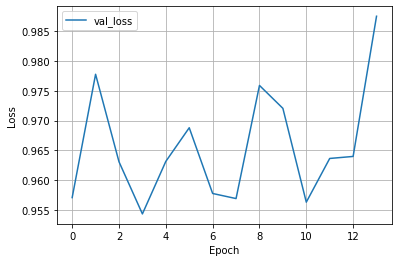

In [11]:
def plot_loss(history):
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.plot(history.history['val_out_seq_loss'], label='val_out_seq_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
plot_loss(history)

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [12]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [13]:
datelist_future

[Timestamp('2021-12-03 00:00:00', freq='D'),
 Timestamp('2021-12-04 00:00:00', freq='D')]

<h3>Step #5. Make predictions for future dates</h3>

In [14]:
# Perform predictions
predictions_train = model.predict(X_train[n_past:])

predictions_future = model.predict(X_train[-n_future:])

In [15]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Target']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Target']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)


,Target
2017-06-29,-0.000920
2017-06-30,-0.001209
2017-07-03,-0.000996


<h3>Step #6. Visualize the Predictions</h3>

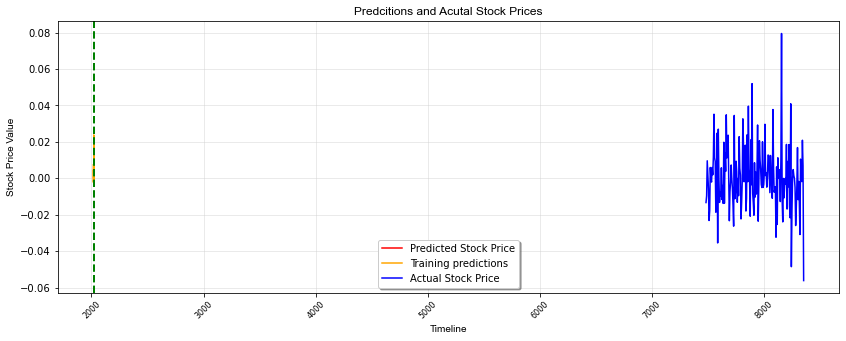

In [16]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Target'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Target'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Target'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [17]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)